In [15]:
import numpy as np
import pandas as pd
import skrf as rf
from pylab import *
from scipy import constants
from skrf import Network, Frequency
from scipy import signal
import matplotlib.pyplot as plt
import itertools

%config InlineBackend.figure_format = 'svg'
plt.rcParams['lines.linewidth'] = 0.8

In [16]:
f_start = 1e9
f_stop = 40e9
f_points = 2000

f = linspace(f_start, f_stop, f_points)

l = 6e-6

## Rework S-Parameters for RLGCK for sensible simulation resukts

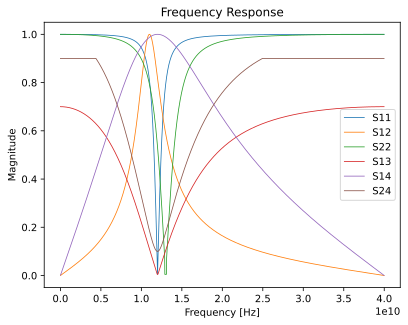

In [17]:
#S11
b, a = signal.iirnotch(w0=12e9, Q=8, fs=2 * f_stop)
w, h11 = signal.freqz(b, a, worN=f_points)
for i in range(f_points):
    h11[i] = max(abs(h11[i]), abs(0.005 + 0j))
    h11[0] = h11[1]


#S12
b, a = signal.iirnotch(w0=11e9, Q=4, fs=2 * f_stop)
w, h12 = signal.freqz(b, a, worN=f_points)
h12 = 1 - h12
h12[0] = h12[1]


#S22
b, a = signal.iirnotch(w0=13e9, Q=4, fs=2 * f_stop)
w, h22 = signal.freqz(b, a, worN=f_points)
for i in range(f_points):
    h22[i] = max(h22[i], 0.005 + 0j)
h22[0] = h22[1]


#S13
b, a = signal.iirnotch(w0=12e9, Q=1, fs=2 * f_stop)
w, h13 = signal.freqz(b, a, worN=f_points)
h13 = h13*0.7
for i in range(f_points):
    h13[i] = max(abs(h13[i]), abs(0.005 + 0j))
h13[0] = h13[1]

#S14
b, a = signal.iirnotch(w0=12e9, Q=1, fs=2 * f_stop)
w, h14 = signal.freqz(b, a, worN=f_points)
h14 = 1 - h14
h14[0] = h14[1]


#S24
b, a = signal.iirnotch(w0=13e9, Q=1, fs=2 * f_stop)
w, h24 = signal.freqz(b, a, worN=f_points)
h24 = 1 - h14*1.1
for i in range(f_points):
    h24[i] = min(abs(h24[i]), abs(0.9 + 0j))
h24[0] = h24[1]

# Plot all responses on the same graph
plt.figure()

plt.plot(f_stop * w / np.pi, np.abs(h11), label='S11')
plt.plot(f_stop * w / np.pi, np.abs(h12), label='S12')
plt.plot(f_stop * w / np.pi, np.abs(h22), label='S22')
plt.plot(f_stop * w / np.pi, np.abs(h13), label='S13')
plt.plot(f_stop * w / np.pi, np.abs(h14), label='S14')
plt.plot(f_stop * w / np.pi, np.abs(h24), label='S24')

plt.xlabel('Frequency [Hz]')
plt.ylabel('Magnitude')
plt.title('Frequency Response')
plt.legend()

plt.show()

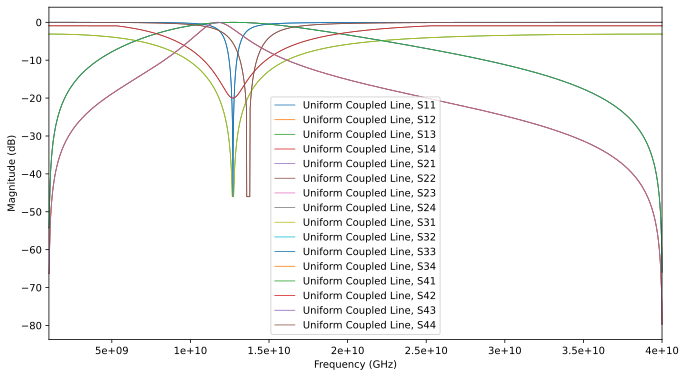

In [18]:
s = np.zeros((f_points, 4, 4), dtype=complex)
s[:,0,0] = h11
s[:,0,1] = h12
s[:,1,0] = h12
s[:,1,1] = h22

s[:,0,2] = h13
s[:,0,3] = h14
s[:,1,2] = h14
s[:,1,3] = h24

s[:,2,2] = h11
s[:,2,3] = h12
s[:,3,2] = h12
s[:,3,3] = h22

s[:,2,0] = h13
s[:,2,1] = h14
s[:,3,0] = h14
s[:,3,1] = h24

# Create an S-parameters Network
ntw_uniform = rf.Network(frequency=f, s=s, z0=[50, 50, 50, 50], name='Uniform Coupled Line')
plt.figure(figsize=(11, 6))
ntw_uniform.plot_s_db()

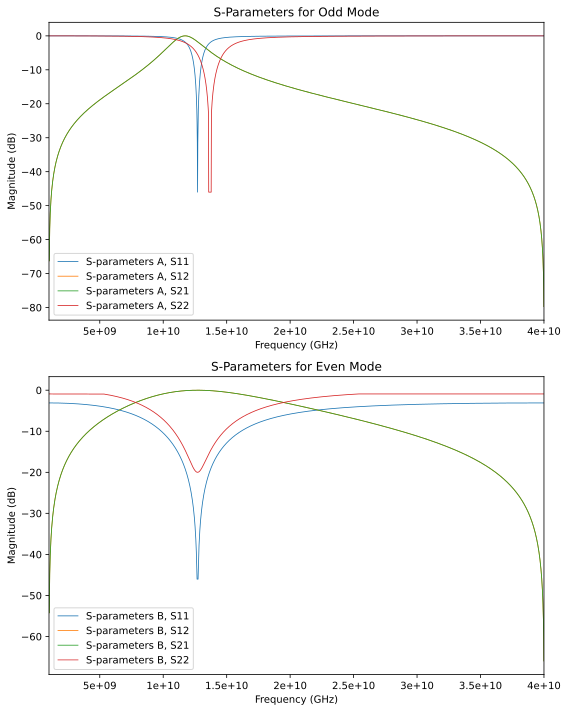

In [19]:
sA = s[:, 0:2, 0:2]
sB = s[:, 0:2, 2:4]

s_odd = (sA+sB)
s_even = (sA-sB)

# Create an S-parameters Network for sA
ntw_A = rf.Network(frequency=f, s=sA, z0=[50, 50], name='S-parameters A')

# Create an S-parameters Network for sB
ntw_B = rf.Network(frequency=f, s=sB, z0=[50, 50], name='S-parameters B')

# Plot the S-parameters on two subplots for odd and even frequencies
fig, axs = plt.subplots(2, 1, figsize=(8, 10))

# Plot for odd frequencies
axs[0].set_title('S-Parameters for Odd Mode')
ntw_A.plot_s_db(ax=axs[0])

# Plot for even frequencies
axs[1].set_title('S-Parameters for Even Mode')
ntw_B.plot_s_db(ax=axs[1])

plt.tight_layout()
plt.show()


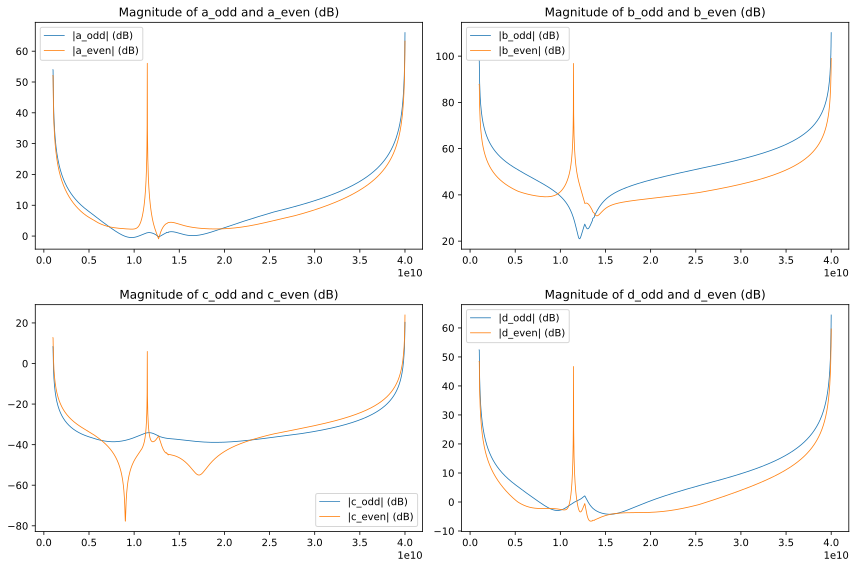

In [20]:
abcd_odd = rf.s2a(s=s_odd, z0=50)
abcd_even = rf.s2a(s=s_even, z0=50)

def plotABCDMagnitudedB(f, abcd_odd, abcd_even):
    a_odd_dB = 20 * np.log10(np.abs(abcd_odd[:, 0, 0]))
    b_odd_dB = 20 * np.log10(np.abs(abcd_odd[:, 0, 1]))
    c_odd_dB = 20 * np.log10(np.abs(abcd_odd[:, 1, 0]))
    d_odd_dB = 20 * np.log10(np.abs(abcd_odd[:, 1, 1]))

    a_even_dB = 20 * np.log10(np.abs(abcd_even[:, 0, 0]))
    b_even_dB = 20 * np.log10(np.abs(abcd_even[:, 0, 1]))
    c_even_dB = 20 * np.log10(np.abs(abcd_even[:, 1, 0]))
    d_even_dB = 20 * np.log10(np.abs(abcd_even[:, 1, 1]))

    fig, axs = plt.subplots(2, 2, figsize=(12, 8))

    axs[0, 0].plot(f, a_odd_dB, label='|a_odd| (dB)')
    axs[0, 0].plot(f, a_even_dB, label='|a_even| (dB)')
    axs[0, 0].set_title('Magnitude of a_odd and a_even (dB)')
    axs[0, 0].legend()

    axs[0, 1].plot(f, b_odd_dB, label='|b_odd| (dB)')
    axs[0, 1].plot(f, b_even_dB, label='|b_even| (dB)')
    axs[0, 1].set_title('Magnitude of b_odd and b_even (dB)')
    axs[0, 1].legend()

    axs[1, 0].plot(f, c_odd_dB, label='|c_odd| (dB)')
    axs[1, 0].plot(f, c_even_dB, label='|c_even| (dB)')
    axs[1, 0].set_title('Magnitude of c_odd and c_even (dB)')
    axs[1, 0].legend()

    axs[1, 1].plot(f, d_odd_dB, label='|d_odd| (dB)')
    axs[1, 1].plot(f, d_even_dB, label='|d_even| (dB)')
    axs[1, 1].set_title('Magnitude of d_odd and d_even (dB)')
    axs[1, 1].legend()

    # Adjust layout
    plt.tight_layout()
    plt.show()

plotABCDMagnitudedB(f, abcd_odd, abcd_even)

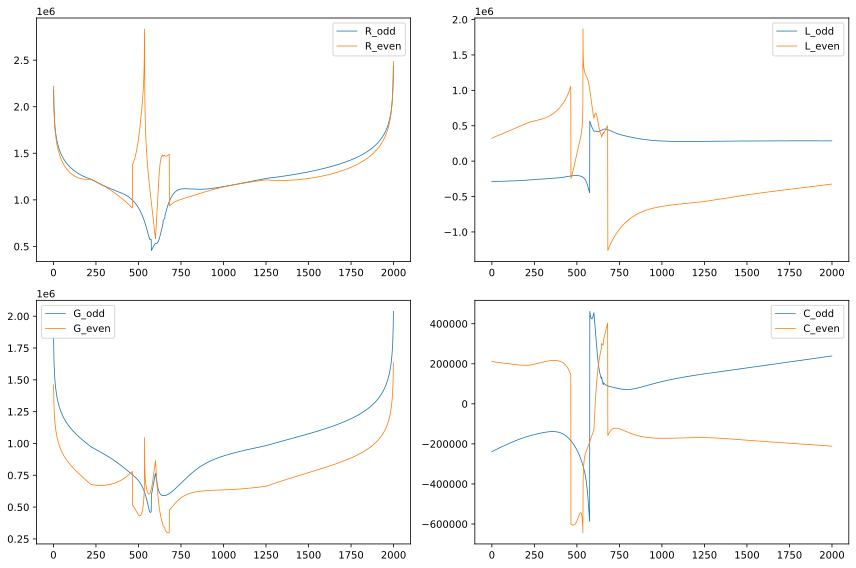

In [21]:
def abcd2rlgc(abcd, l):
    a = abcd[:, 0, 0]
    b = abcd[:, 0, 1]
    c = abcd[:, 1, 0]
    d = abcd[:, 1, 1]

    Z0 = np.sqrt(a/d)
    gamma = np.arccosh(b)/l

    R = np.real(gamma*Z0)
    L = np.imag(gamma*Z0)
    G = np.real(gamma/Z0)
    C = np.imag(gamma/Z0)

    return R, L, G, C


R_odd, L_odd, G_odd, C_odd = abcd2rlgc(abcd_odd, l)
R_even, L_even, G_even, C_even = abcd2rlgc(abcd_even, l)

Cm = (C_odd + C_even)/2
Ca = C_even

Cst = max(Cm)*10

Gm = (G_odd - G_even)/2
Ga = G_even

def plotRLGC(R_odd, L_odd, G_odd, C_odd, R_even, L_even, G_even, C_even):
    fig, axs = plt.subplots(2, 2, figsize=(12, 8))

    # Plot RLGC for odd variant
    axs[0, 0].plot(R_odd, label='R_odd')
    axs[0, 0].plot(R_even, label='R_even')
    axs[0, 0].legend()

    axs[0, 1].plot(L_odd, label='L_odd')
    axs[0, 1].plot(L_even, label='L_even')
    axs[0, 1].legend()

    # Plot RLGC for even variant
    axs[1, 0].plot(G_odd, label='G_odd')
    axs[1, 0].plot(G_even, label='G_even')
    axs[1, 0].legend()

    axs[1, 1].plot(C_odd, label='C_odd')
    axs[1, 1].plot(C_even, label='C_even')
    axs[1, 1].legend()

    # Adjust layout
    plt.tight_layout()
    plt.show()

plotRLGC(R_odd, L_odd, G_odd, C_odd, R_even, L_even, G_even, C_even)

## Derivation of Algorithm Backwards

In [22]:
def odd_mode_params(f, L_odd, Cm, Ca, Gm, Ga, R):
    w = 2 * np.pi * f
    C_odd = 2 * Cm - Ca
    G_odd = 2 * Gm + Ga
    R_odd = R
    
    gamma_odd = np.sqrt((1j * w * L_odd + R_odd) * (1j * w * C_odd + G_odd))
    Z0_odd = np.sqrt((R_odd + 1j * w * L_odd) / (G_odd + 1j * w * C_odd))
    
    f0_o = 1 / (2 * np.pi * np.sqrt(L_odd * C_odd))
    theta_odd = (np.pi / 2) * (f / f0_o)
    
    return L_odd, C_odd, G_odd, R_odd, gamma_odd, Z0_odd, theta_odd

def even_mode_params(f, L_even, Cm, Ca, Gm, Ga, R):
    w = 2 * np.pi * f
    C_even = Ca
    G_even = Ga
    R_even = R
    
    gamma_even = np.sqrt((1j * w * L_even + R_even) * (1j * w * C_even + G_even))
    Z0_even = np.sqrt((R_even + 1j * w * L_even) / (G_even + 1j * w * C_even))
    
    f0_e = 1 / (2 * np.pi * np.sqrt(L_even * C_even))
    theta_even = (np.pi / 2) * (f / f0_e)
    
    return L_even, C_even, G_even, R_even, gamma_even, Z0_even, theta_even



In [23]:
def find_Zin(ZL, Zc, gamma, l):
    return Zc * ((ZL + 1j * Zc * np.tan(gamma * l)) / (Zc + 1j * ZL * np.tan(gamma * l)))

def find_Zc(f, R, L, G, C):
    w = 2 * np.pi * f
    return np.sqrt((R + 1j * w * L) / (G + 1j * w * C))

def Z0_even_odd_on_off(f, L_odd, L_even, Cm, Ca, C_shunt, Gm, Ga, R_odd, R_even):
    _, _, _, _, gamma_odd_off, Z0_odd_off, theta_o_off = odd_mode_params(f, L_odd, Cm, Ca, Gm, Ga, R_odd)
    _, _, _, _, gamma_even_off, Z0_even_off, theta_e_off = even_mode_params(f, L_even, Cm, Ca, Gm, Ga, R_odd)
    
    _, _, _, _, gamma_odd_on, Z0_odd_on, theta_o_on = odd_mode_params(f, L_odd, Cm + C_shunt, Ca, Gm, Ga, R_even)
    _, _, _, _, gamma_even_on, Z0_even_on, theta_e_on = even_mode_params(f, L_even, Cm, Ca, Gm, Ga, R_even)
    
    return Z0_odd_off, Z0_odd_on, Z0_even_off, Z0_even_on, gamma_odd_off, gamma_odd_on, gamma_even_off, gamma_even_on, theta_o_off, theta_o_on, theta_e_off, theta_e_on

def find_all_Zins(Z0_odd_off, Z0_odd_on, Z0_even_off, Z0_even_on, gamma_odd_off, gamma_odd_on, gamma_even_off, gamma_even_on, l, ZL):
    Zin_o_off = find_Zin(ZL, Z0_odd_off, gamma_odd_off, l)
    Zin_o_on = find_Zin(ZL, Z0_odd_on, gamma_odd_on, l)
    Zin_e_off = find_Zin(ZL, Z0_even_off, gamma_even_off, l)
    Zin_e_on = find_Zin(ZL, Z0_even_on, gamma_even_on, l)
    
    return Zin_o_off, Zin_o_on, Zin_e_off, Zin_e_on

def find_Zin_for_curr_section(num_of_sections, j, Z0_curr, gamma, l, f):
    Z01 = 50 * np.ones_like(f)
    Z03 = Z01

    if num_of_sections == 1:
        Z02 = Z01
        Z04 = Z03
        return Z01, Z02, Z03, Z04

    for i in range(1, j + 1):
        Z01 = find_Zin(Z01, Z0_curr, gamma, l)

    for i in range(num_of_sections, j, -1):
        Z03 = find_Zin(Z03, Z0_curr, gamma, l)

    Z02 = Z01
    Z04 = Z03

    return Z01, Z02, Z03, Z04

def plot_dual_axes(subplot, freq, data_real, data_imag, title):
    ax1 = subplot.twinx()
    subplot.plot(freq, data_real, 'b-', label='Real')
    ax1.plot(freq, data_imag, 'r-', label='Imag')
    
    subplot.set_xlabel('Frequency')
    subplot.set_title(title)
    subplot.legend(loc='upper left')
    ax1.legend(loc='upper right')
    
def plot_subplots(Z_odd, Z_even, freq):
    fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(16, 8), sharex=True)

    for i, Z in enumerate(Z_odd):
        plot_dual_axes(axes[0, i], freq, np.real(Z), np.imag(Z), f'Z0{i+1}_odd')

    for i, Z in enumerate(Z_even):
        plot_dual_axes(axes[1, i], freq, np.real(Z), np.imag(Z), f'Z0{i+1}_even')

    plt.tight_layout()
    plt.show()

In [24]:
def create_A_matrix(gamma_odd, gamma_even, Z0_odd, Z0_even, l):
    abcd_odd = np.zeros((len(gamma_odd), 2, 2), dtype=complex)
    abcd_even = np.zeros_like(abcd_odd)

    abcd_odd[:, 0, 0] = np.cosh(gamma_odd * l)
    abcd_odd[:, 0, 1] = 1j * Z0_odd * np.sinh(gamma_odd * l)
    abcd_odd[:, 1, 0] = (1j / Z0_odd) * np.sinh(gamma_odd * l)
    abcd_odd[:, 1, 1] = np.cosh(gamma_odd * l)

    abcd_even[:, 0, 0] = np.cosh(gamma_even * l)
    abcd_even[:, 0, 1] = 1j * Z0_even * np.sinh(gamma_even * l)
    abcd_even[:, 1, 0] = (1j / Z0_even) * np.sinh(gamma_even * l)
    abcd_even[:, 1, 1] = np.cosh(gamma_even * l)

    #print("shape of ABCD = ", shape(abcd_odd))

    return abcd_odd, abcd_even

def create_on_off_A_matrices(gamma_odd_off, gamma_even_off, Z0_odd_off, Z0_even_off, gamma_odd_on, gamma_even_on, Z0_odd_on, Z0_even_on, l):
    # Assuming create_A_matrix is a valid function
    abcd_odd_off, abcd_even_off = create_A_matrix(gamma_odd_off, gamma_even_off, Z0_odd_off, Z0_even_off, l)
    abcd_odd_on, abcd_even_on = create_A_matrix(gamma_odd_on, gamma_even_on, Z0_odd_on, Z0_even_on, l)
    return abcd_odd_off, abcd_even_off, abcd_odd_on, abcd_even_on


def convert_section_to_S(abcd_odd, abcd_even, Z01_odd, Z02_odd, Z03_odd, Z04_odd, Z01_even, Z02_even, Z03_even, Z04_even):
    Z0i_odd = np.concatenate((Z01_odd, Z04_odd), axis=0).reshape(len(Z01_odd), 2)
    Z0i_even = np.concatenate((Z01_even, Z04_even), axis=0).reshape(len(Z01_odd), 2)

    s_odd = rf.a2s(abcd_odd, z0=Z0i_odd)
    s_even = rf.a2s(abcd_even, z0=Z0i_even)

    sA = (s_odd+s_even)/2
    sB = (s_odd-s_even)/2

    s = np.zeros((len(Z01_odd), 4, 4), dtype=complex)
    s[:, 0:2, 0:2] = sA
    s[:, 2:4, 2:4] = sA

    s[:, 0:2, 2:4] = sB
    s[:, 2:4, 0:2] = sB
    return s

In [25]:
def multiply_mat(A, B):
    C = np.zeros_like(A, dtype=complex)
    for i in range(len(A[:, 0, 0])):
        C[i, :, :] = A[i, :, :] @ B[i, :, :]

    return C

In [26]:
def plot_dual_yaxes1(ax, x, y1, y2, label1, label2, title):
    ax2 = ax.twinx()
    ax.plot(x, y1, label=label1, color='b')
    ax2.plot(x, y2, label=label2, color='r')
    ax.set_ylabel(label1, color='b')
    ax2.set_ylabel(label2, color='r')
    ax.set_title(title)

def plot_4_quantities(quantity_odd_off, quantity_odd_on, quantity_even_off, quantity_even_on, quantity_name):
    fig, axes = plt.subplots(2, 2)

    # Plot quantity_odd_off
    axes[0, 0].plot(quantity_odd_off.real, quantity_odd_off.imag)
    axes[0, 0].set_title(f"{quantity_name} Odd Off")
    axes[0, 0].set_xlabel("Real")
    axes[0, 0].set_ylabel("Imaginary")

    # Plot quantity_odd_on
    axes[0, 1].plot(quantity_odd_on.real, quantity_odd_on.imag)
    axes[0, 1].set_title(f"{quantity_name} Odd On")
    axes[0, 1].set_xlabel("Real")
    axes[0, 1].set_ylabel("Imaginary")

    # Plot quantity_even_off
    axes[1, 0].plot(quantity_even_off.real, quantity_even_off.imag)
    axes[1, 0].set_title(f"{quantity_name} Even Off")
    axes[1, 0].set_xlabel("Real")
    axes[1, 0].set_ylabel("Imaginary")

    # Plot quantity_even_on
    axes[1, 1].plot(quantity_even_on.real, quantity_even_on.imag)
    axes[1, 1].set_title(f"{quantity_name} Even On")
    axes[1, 1].set_xlabel("Real")
    axes[1, 1].set_ylabel("Imaginary")

    plt.tight_layout()
    plt.show()

/var/folders/v1/t149q84d20s60ktyxvb3bft40000gn/T/ipykernel_7583/2220548972.py:24: RuntimeWarning: invalid value encountered in sqrt
  f0_e = 1 / (2 * np.pi * np.sqrt(L_even * C_even))
/var/folders/v1/t149q84d20s60ktyxvb3bft40000gn/T/ipykernel_7583/2220548972.py:10: RuntimeWarning: invalid value encountered in sqrt
  f0_o = 1 / (2 * np.pi * np.sqrt(L_odd * C_odd))


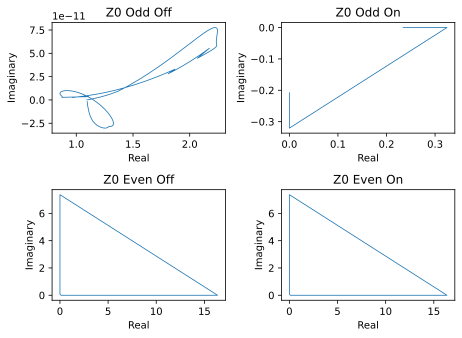

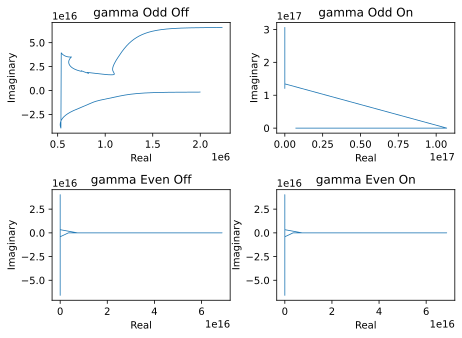

/var/folders/v1/t149q84d20s60ktyxvb3bft40000gn/T/ipykernel_7583/875480116.py:10: RuntimeWarning: overflow encountered in cosh
  abcd_even[:, 0, 0] = np.cosh(gamma_even * l)
/var/folders/v1/t149q84d20s60ktyxvb3bft40000gn/T/ipykernel_7583/875480116.py:11: RuntimeWarning: overflow encountered in sinh
  abcd_even[:, 0, 1] = 1j * Z0_even * np.sinh(gamma_even * l)
/var/folders/v1/t149q84d20s60ktyxvb3bft40000gn/T/ipykernel_7583/875480116.py:11: RuntimeWarning: invalid value encountered in multiply
  abcd_even[:, 0, 1] = 1j * Z0_even * np.sinh(gamma_even * l)
/var/folders/v1/t149q84d20s60ktyxvb3bft40000gn/T/ipykernel_7583/875480116.py:12: RuntimeWarning: overflow encountered in sinh
  abcd_even[:, 1, 0] = (1j / Z0_even) * np.sinh(gamma_even * l)
/var/folders/v1/t149q84d20s60ktyxvb3bft40000gn/T/ipykernel_7583/875480116.py:12: RuntimeWarning: invalid value encountered in multiply
  abcd_even[:, 1, 0] = (1j / Z0_even) * np.sinh(gamma_even * l)
/var/folders/v1/t149q84d20s60ktyxvb3bft40000gn/T/ipyk

In [27]:
num_of_sections = 3
num_of_combinations = 2**num_of_sections

# Generate all possible combinations of an 8-bit input
input_combinations = list(itertools.product([0, 1], repeat=num_of_sections))

# Convert the combinations to a NumPy array
input_matrix = np.array(input_combinations)

# Create the matrix I with the specified shape
I = np.zeros((f_points, 4, 4), dtype=complex)

Z0_odd_off, Z0_odd_on, Z0_even_off, Z0_even_on, gamma_odd_off, gamma_odd_on, gamma_even_off, gamma_even_on, theta_o_off, theta_o_on, theta_e_off, theta_e_on = Z0_even_odd_on_off(f, L_odd, L_even, Cm, Ca, Cst, Gm, Ga, R_odd, R_even)
plot_4_quantities(Z0_odd_off, Z0_odd_on, Z0_even_off, Z0_even_on, "Z0")
plot_4_quantities(gamma_odd_off, gamma_odd_on, gamma_even_off, gamma_even_on, "gamma")

abcd_odd_off, abcd_even_off, abcd_odd_on, abcd_even_on = create_on_off_A_matrices(gamma_odd_off, gamma_even_off, Z0_odd_off, Z0_even_off, gamma_odd_on, gamma_even_on, Z0_odd_on, Z0_even_on, l)

# Fill each slice with an identity matrix
for i in range(f_points):
    I[i, :, :] = np.eye(4, dtype=complex)

S_storage = {}

for index in range(num_of_combinations):
    S = I
    for j in range(num_of_sections):
        if (input_matrix[index, j] == 1):
            Z01_odd, Z02_odd, Z03_odd, Z04_odd = find_Zin_for_curr_section(num_of_sections, j, find_Zc(f, R_odd, L_odd, G_odd, C_odd+Cst), gamma_odd_on, l, f)
            Z01_even, Z02_even, Z03_even, Z04_even = find_Zin_for_curr_section(num_of_sections, j, find_Zc(f, R_even, L_even, G_even, C_even), gamma_even_on, l, f)

            #plot_subplots([Z01_odd, Z02_odd, Z03_odd, Z04_odd], [Z01_even, Z02_even, Z03_even, Z04_even], f)

            S_curr = convert_section_to_S(abcd_odd_on, abcd_even_on, Z01_odd, Z02_odd, Z03_odd, Z04_odd, Z01_even, Z02_even, Z03_even, Z04_even)
            S = multiply_mat(S, S_curr)
        else:
            Z01_odd, Z02_odd, Z03_odd, Z04_odd = find_Zin_for_curr_section(num_of_sections, j, find_Zc(f, R_odd, L_odd, G_odd, C_odd), gamma_odd_on, l, f)
            Z01_even, Z02_even, Z03_even, Z04_even = find_Zin_for_curr_section(num_of_sections, j, find_Zc(f, R_even, L_even, G_even, C_even), gamma_even_on, l, f)

            #plot_subplots([Z01_odd, Z02_odd, Z03_odd, Z04_odd], [Z01_even, Z02_even, Z03_even, Z04_even], f)

            S_curr = convert_section_to_S(abcd_odd_off, abcd_even_off, Z01_odd, Z02_odd, Z03_odd, Z04_odd, Z01_even, Z02_even, Z03_even, Z04_even)
            S = multiply_mat(S, S_curr)
    S_storage[index] = S

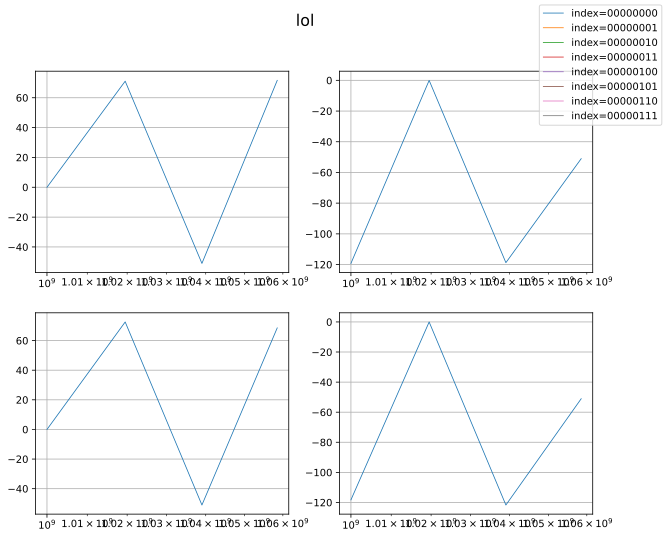

In [28]:
def moving_average(data, window_size):
    """Calculate the moving average of a 1D array."""
    cumsum = np.cumsum(data)
    cumsum[window_size:] = cumsum[window_size:] - cumsum[:-window_size]
    return cumsum[window_size - 1:] / window_size

def plot_all_possible_S_params(f, S_storage, title, n, smooth_window=1):
    N = len(S_storage)
    gridSize = int(np.ceil(np.sqrt(4)))
    fig_S_params, ax = plt.subplots(gridSize, gridSize, figsize=(10, 8))

    # Create a list of legend entries
    legend_entries = []
    for j in range(0, N, int(N/n)):
        legend_entries.append(f"index={format(j, f'0{8}b')}")

    # Add a legend to each subplot
    for i in range(4):
        for j in range(0, N, int(N/n)):
            # Smooth the S-parameter data
            smoothed_S = moving_average(20*np.log10(np.abs(S_storage[j][int(i/2), i%2, :])), smooth_window)
            line, = ax.flat[i].semilogx(f[:len(smoothed_S)], smoothed_S)
        ax.flat[i].grid(True)  # Add grid lines

    # Set a common title for all subplots
    fig_S_params.suptitle(title, fontsize=16)
    fig_S_params.legend(legend_entries)
    

plot_all_possible_S_params(f, S_storage, "lol", 8, smooth_window=1)